In [3]:
# Descarga de archivos de ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip  profner.zip?download=1

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: profner/subtask-1/test-background-txt-files/1243953060050763778.txt  
  inflating: profner/subtask-1/test-background-txt-files/1243988693947486209.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244173600753618945.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244319340062822405.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247000104193712129.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247263989249212416.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247465550931988482.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249075777544556545.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249253729720766466.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249964965546668034.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249980196838682624.txt  
  inflating: profner/subta

Funciones de carga y preparación de datos

In [4]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt 
    que se introduce en su entrada. 
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()
  
  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

In [5]:
!pip install emoji_extractor
!pip install emoji
import sys  
!{sys.executable} -m pip install contractions
!pip install spacy==3.2.1
!python -m spacy download es_core_news_sm
import nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for emoji_extractor: filename=emoji_extractor-2.0.0-py3-none-any.whl size=64179 sha256=23dd57dbe70f9932dcb448050e54f28e7dc83b0082353b3cbbb9021c823d81e2
  Stored in directory: /root/.cache/pip/wheels/bc/19/3e/71f5556fb752e1e50e9d083f5022a54232b22efdf90a507ea1
Successfully built emoji_extractor
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=731addec13c487faa37797799cff963299a90e589fdc0a1cd8b85c081eade081
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji
Looking in indexes: https://pypi.org/simple, htt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Ejercicio


## 0. Imports


In [6]:
#Librerías típicas
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype,is_object_dtype
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import contractions
import re
from emoji_extractor.extract import Extractor
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.4.1) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.2.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [7]:
# Instalamos textacy
!pip install textacy
# Instalamos spacy y uno de sus modelos
!pip install spacy
# Descargamos modelos pre-entrenados de spacy.
!python -m spacy download es_core_news_sm
import spacy
nlp = spacy.load("es_core_news_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.4/208.4 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 KB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.6 MB/s eta 0:00:00
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp38-cp38-linux_x86_64.whl size=77908 sha256=8344fddaeea98642d7aeed38f7a36c7078c862db6931960ba8a0740e993791e1
  Stored in directory: /root/.cache/pip/wheels/f1/c7/3c/4c83132de76359e3a429fd09c08995945ca96c5290a41651d3
Successfully built jellyfish
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVM

In [8]:
# Instalamos nltk
!pip install nltk
# Importamos
import nltk
# Complementos de la librería necesarios para su funcionamiento.
# Todas las opciones aquí https://www.nltk.org/nltk_data/ 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [9]:
profner_path = "./profner/"
datos_ejercicio = get_profner_data(profner_path)

In [10]:
datos_ejercicio.head(4)

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train


## 2. Análisis exploratorio

### 2.1 Visualizar contenido tweets

En este apartado pretendemos realizar un análisis de los datos previo a la normalización de los mismos. Este análisis nos va a permitir extraer información relevante del dataset, así como posibles inconvenientes que serán solucionados llegado el caso.

* **Número de documentos y columnas:**

Mostramos el número de documentos que tiene nuestro dataframe así como el número de columnas

In [11]:
print("Tenemos un conjunto de {} documentos".format(len(datos_ejercicio)))
print("El dataframe tiene {} columnas".format(datos_ejercicio.shape[1]))

Tenemos un conjunto de 8000 documentos
El dataframe tiene 4 columnas


* **Elementos duplicados:**

Comprobamos si el dataset que hemos recibido tiene alguna fila duplicada, en cuyo caso habría que eliminarla.

In [12]:
# Analizamos si nuestro dataset tiene filas duplicadas
duplicated = datos_ejercicio.duplicated().sum()
print(f'El dataset tiene {duplicated} filas duplicadas.')

El dataset tiene 0 filas duplicadas.


* **Tipo de columnas:**

Es importante saber cual es el tipo de cada una de las columnas. Utilizaremos la función info para saberlo.

In [13]:
# Tipo de cada columna
datos_ejercicio.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    8000 non-null   int64 
 1   tweet_text  8000 non-null   object
 2   label       8000 non-null   int64 
 3   set         8000 non-null   object
dtypes: int64(2), object(2)
memory usage: 250.1+ KB


Observamos que tenemos dos columnas numéricas y dos categóricas

### 2.2 Número de elementos duplicados o NA

Comprobamos y eliminamos si tenemos alguna fila con algún valor vacío (NA) y quitamos los duplicados

In [14]:
print("Existen {} noticias duplicadas".format(np.sum(datos_ejercicio.duplicated(subset=["tweet_text"]))))
# Quitaremos esos duplicados
dataset = datos_ejercicio.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} noticias".format(dataset.shape[0]))

Existen 0 noticias duplicadas
Despues de quitar duplicados tenemos un conjunto de 8000 noticias


Comprobaramos que no hayan quedado Nulls en ningunas de las dos columnas del dataset

In [15]:
print("Hay {} valores vacíos en las noticias y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],
                                                                                                        np.sum(dataset.isnull())[1]))

Hay 0 valores vacíos en las noticias y 0 valores vacíos en las etiquetas en los datos


### 2.3 Balanceo de clases

* **Número de documentos por cada label:**:

Contamos el número de elementos de cada label. Vemos que en la columna "label" nos encontramos las etiquetas del dataset. En este caso nos encontramos dos tipos de documentos (tweets):

- "Label = 1": Tweets con presencia de menciones de profesiones
- "Label = 0": Tweets sin presencia de menciones de profesiones

In [16]:
from nltk.downloader import Label
dataset.groupby(["label"]).count()

,tweet_id,tweet_text,set
label,,,
0,6130,6130,6130
1,1870,1870,1870


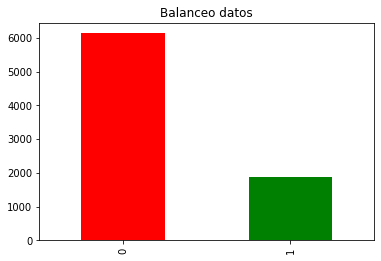

In [17]:
ax, fig = plt.subplots()
etiquetas = dataset.label.value_counts()
etiquetas.plot(kind= 'bar', color= ["red", "green"])
plt.title('Balanceo datos')
plt.show()

Podemos observar que no tenemos unos datos balanceados sino que tenemos mucha mayor proporción de tweets donde NO se menciona la profesión que tweets donde sí se menciona, en una proporción mayor a 3:1.
En pasos posteriores para poder hacer una predición certera tendremos que balancear nuestra variable target.

### 2.4 Longitud de caracteres

* **Distribución de la longitud de los tweet en caracteres:**

Para seguir con el análisis exploratorio, vamos a hacer un cálculo típico: la longitud de cada uno de los textos de los documentos para despues dibujar su histograma. 

Comenzamos creando las columnas que van a almacenar las longitud en caracteres y en tokens de los documentos del corpus:

In [18]:
dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


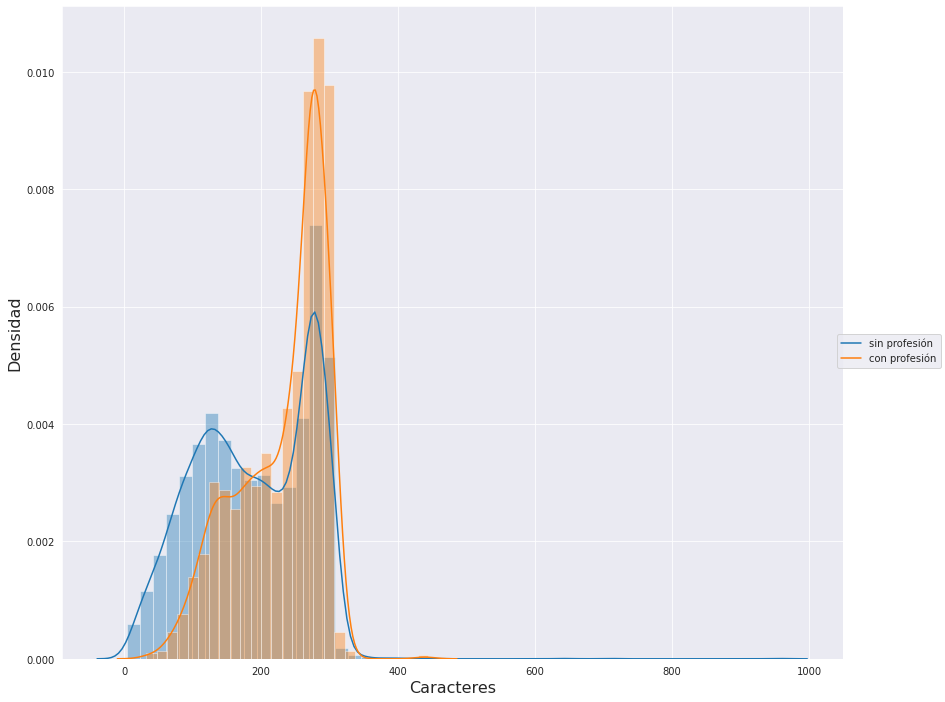

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len
plt1 = sns.distplot(dataset[dataset.label==0].char_len, hist=True, label="sin profesión")
plt2 = sns.distplot(dataset[dataset.label==1].char_len, hist=True, label="con profesión")
fig.legend(labels=['sin profesión','con profesión'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

No podemos llegar a ninguna conclusión con este gráfico ya que aunque tengamos una mayor densidad de tweets "con profesión" de más carácteres, la diferencia no es muy significativa respecto a "sin profesión". Quizás los tweets donde no aparece la profesión son algo más cortos, pero no es muy destacable.

### 2.5 Wordcloud

Vamos a generar un wordcloud para de esta manera poder visualizar facilmente cuáles son las palabras más repetidas en el dataset.

Primero generamos una variable llamada "text" donde almacenamos todos los elementos de la columna que nos interesa analizar del dataset, que es "tweet_text"

In [20]:
text = " ".join(i for i in datos_ejercicio.tweet_text)

Tenemos que eliminar las "stopwords" de nuestro wordclud, ya que no nos van a aportar ninguna información valiosa.

Actualizamos los stopwords para incluirle algunas palabras que no aparecen y que sino se nos van a repetir mucho sin aportarnos valor.

In [21]:
import nltk
from nltk.corpus import stopwords

print(stopwords.words('spanish'))
stopwords = set(stopwords.words('spanish'))
stopwords.update(["t", "co", "http", "https"])


['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

Generamos un Wordcloud con la función WordCloud y lo printeamos para poder ver el resultado

In [22]:
word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords= stopwords,
        ).generate(text)

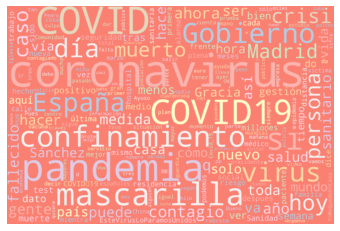

In [23]:
plt.figure()
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Realizando este wordcloud podemos observar en un análisis previo que las palabras más repetidas están relacionadas con la pandema ("COVID19", "coronavirus", "pandemia", "mascarilla", "COVID"). Luego podemos asegurar que durante la época que fueron escritos estos tweets estos fueron los temas que más preocuparon a los tweeteros.

## 3. Preprocesado y Normalización

### 3.1 Preprocesado y normalización

De cara a preprocesar y normalizar los datos empezaremos generando una función que sigue los siguientes pasos:

- Primero llamamos a un objeto de la clase TweetTokenizer del paquete nltk.tokenize. Este tokenizador es especialmente diseñado para tokenizar tweets y se encarga de dividir los tweets en tokens de manera adecuada, teniendo en cuenta características específicas de los tweets, como los usuarios mencionados (que comienzan con "@") y las emoticonos.
- Después almacenamos en la variable datos_ejercicio el resultado de la función re.sub() con una expresión regular para reemplazar todos los caracteres que no sean palabras, números, signos de puntuación o arroba por un string vacío (es decir, se eliminan).
- Luego, se vuelve a utilizar la función re.sub() para reemplazar múltiples espacios consecutivos con un solo espacio.
- Finalmente, se aplica la función lower() para convertir todos los caracteres en minúsculas.
- Luego, los datos resultantes se tokenizan mediante la función tweet_tokenizer.tokenize() y se almacenan en la variable datos_ejercicio.
- Posteriormente se carga un set de Stopwords en español para filtrar las palabras vacías de los tokens obtenidos en el proceso de tokenización.
- Por último se almacena toda la información en la variable datos_ejercicio que no esté dentro de stopwords.

In [25]:
def preprocesado(text):
    # Creamos una variable con TweetTokenizer()
    tweet_tokenizer = TweetTokenizer()
    # Utilizamos la función para tokenizar combinada para convertir todos los tokens a minúsculas
    # y también eliminar los caracteres especiales 
    datos_ejercicio = tweet_tokenizer.tokenize(re.sub(r'[^\w\s@#]','',re.sub(' +', ' ',text.lower())))
    # Eliminamos las stopwords (en español)
    stop_words = set(stopwords.words("spanish"))
    datos_ejercicio = [w for w in datos_ejercicio if not w in stop_words]

    return(datos_ejercicio)

Ahora creamos una columna llamada "Normalized" donde almacenamos el resultado de haberle aplicado previamente la función generada a la columna "tweet_text" y posteriormente mostramos el resultado.

In [27]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype,is_object_dtype
from nltk.corpus import stopwords
from sklearn.metrics import classification_report

datos_ejercicio['Normalized'] = datos_ejercicio['tweet_text'].apply(lambda x: preprocesado(x))
datos_ejercicio['Normalized'].head()

0    [china, libera, pandemia, eeuu, libera, ovnis,...
1    [san, francisco, eeuu, hace, 100, años, tras, ...
2    [porfi, poneos, mascarilla, 28, nuevas, cancio...
3    [nuevo, covid, normas, reglas, recibimiento, c...
4    [si, confinamiento, dejado, tocada, estabilida...
Name: Normalized, dtype: object

In [28]:
# Comprobamos que nuestros pasos están funcionando perfectamente
datos_ejercicio

,tweet_id,tweet_text,label,set,Normalized
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,"[china, libera, pandemia, eeuu, libera, ovnis,..."
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,"[san, francisco, eeuu, hace, 100, años, tras, ..."
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,"[porfi, poneos, mascarilla, 28, nuevas, cancio..."
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train,"[nuevo, covid, normas, reglas, recibimiento, c..."
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train,"[si, confinamiento, dejado, tocada, estabilida..."
...,...,...,...,...,...
7995,1263939682662002689,#LoMásLeído | Los nuevos infectados de coronav...,0,valid,"[#lomásleído, nuevos, infectados, coronavirus,..."
7996,1259976635891306516,Ayuso adjudica a dedo un contrato de 30.000 eu...,1,valid,"[ayuso, adjudica, dedo, contrato, 30000, euros..."
7997,1277128552153055232,Meses encerrados. Se puede viajar a otras prov...,0,valid,"[meses, encerrados, puede, viajar, provincias,..."
7998,1267915731422916613,El gobierno prohíbe por ley lis despidos duran...,0,valid,"[gobierno, prohíbe, ley, lis, despidos, crisis..."


Ahora vamos a realizar algunos cambios que nos van a ayudar en el preprocesado y la normalización de nuestro dataset:
- Sustituir todas las menciones por "MENTION", de esta manera podemos contabilizarlas
- Sustituir todas las urls o enlaces por "URL", así podremos contarlas también.
- Contabilizar el número total de hashtags.

De esta manera proporcionaremos una información adicional a nuestro dataset que nos podría ser muy útil de cara a interpretarlo.

In [29]:
# Función para reemplazar menciones por "MENTION"
def replace_mentions(tokens):
    return [word if not word.startswith("@") else "MENTION" for word in tokens]

# Aplicamos la función a la columna "Normalized"
datos_ejercicio["Normalized"] = datos_ejercicio["Normalized"].apply(lambda x: replace_mentions(x))

# Creamos una columna con el número total de menciones
datos_ejercicio["MENTION_count"] = datos_ejercicio["Normalized"].apply(lambda x: x.count("MENTION"))

# Mostramos el número total
print("El número total de menciones es: ", datos_ejercicio["MENTION_count"].sum())

El número total de menciones es:  4100


In [30]:
# Función para reemplazar urls por "URL"
def replace_urls(tokens):
    return [word if not re.match("(http|ftp|https):\/\/[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?", word) else "URL" for word in tokens]

# Aplicamos la función a la columna "Normalized"
datos_ejercicio["Normalized"] = datos_ejercicio["Normalized"].apply(lambda x: replace_urls(x))

# Creamos una columna con el número total de URLs
datos_ejercicio["URL_count"] = datos_ejercicio["Normalized"].apply(lambda x: x.count("URL"))

# Mostramos el número total
print("El número total de URLs es: ", datos_ejercicio["URL_count"].sum())

El número total de URLs es:  0


In [31]:
# Creamos una columna con el número total de hashtags
datos_ejercicio["hashtags_count"] = datos_ejercicio["Normalized"].apply(lambda x: sum([1 for i in x if i.startswith("#")]))

# Mostramos el número total
print("El número total de hashtags es: ", datos_ejercicio["hashtags_count"].sum())

El número total de hashtags es:  5771


### 3.2 Lematización

Como proceso extra de normalización vamos a utilizar la lematización, la cual es un proceso de procesamiento de lenguaje natural que reduce las palabras a su forma base o raíz, lo que puede ayudar a normalizar un dataset en cierta medida.

In [32]:
#Importamos las funciones necesarias
!pip install spacy==3.2.1
!python -m spacy download es_core_news_sm
import es_core_news_sm
from tqdm import tqdm
tqdm.pandas()

# Lemmatization de los tokens. Devuelve una string entera para hacer la tokenización
# con NLTK
nlp = es_core_news_sm.load(disable=['parser', 'ner'])
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Extraemos el text en una string
    return " ".join(mytokens)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-21 20:31:40.758930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-21 20:31:40.759066: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-21 20:31:40.759087: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries.

In [33]:
# Aplicamos la función que hemos creado de lematización a nuestra columna 'Normalized'
# Hemos utilizado 'progress_apply' en lugar del método 'apply' regular para ver el progreso de la función
datos_ejercicio['Normalized'] = datos_ejercicio['Normalized'].progress_apply(lambda x: lematizar(x))

100%|██████████| 8000/8000 [00:41<00:00, 193.53it/s]


In [34]:
# Mostramos un ejemplo de nuestra colummna para ver que el lematizado ha funcionado correctamente
datos_ejercicio['Normalized'].iloc[2]

'porfi poneo mascarillar 28 nuevo canción artista colaborar rozalén'

Una vez concluídos estos pasos daremos por finalizado el preprocesado y normalización de nuestro dataset

## 4. Vectorización

Para realizar la vectorización del modelo utilizaremos embeddings, los cuales son una técnica de modelización de lenguaje que permite representar palabras mediante vectores densos (*dense vectors*), de menor tamaño que los obtenidos tras _one-hot enconding_, y que además tienen capacidad de representar contenido semántico.

Utilizaremos embeddings estáticos, normalmente se utilizan word2vec, pero es una librería que funciona para datasets en inglés, como nuestro dataset está en español utilizaremos KeyedVectors.

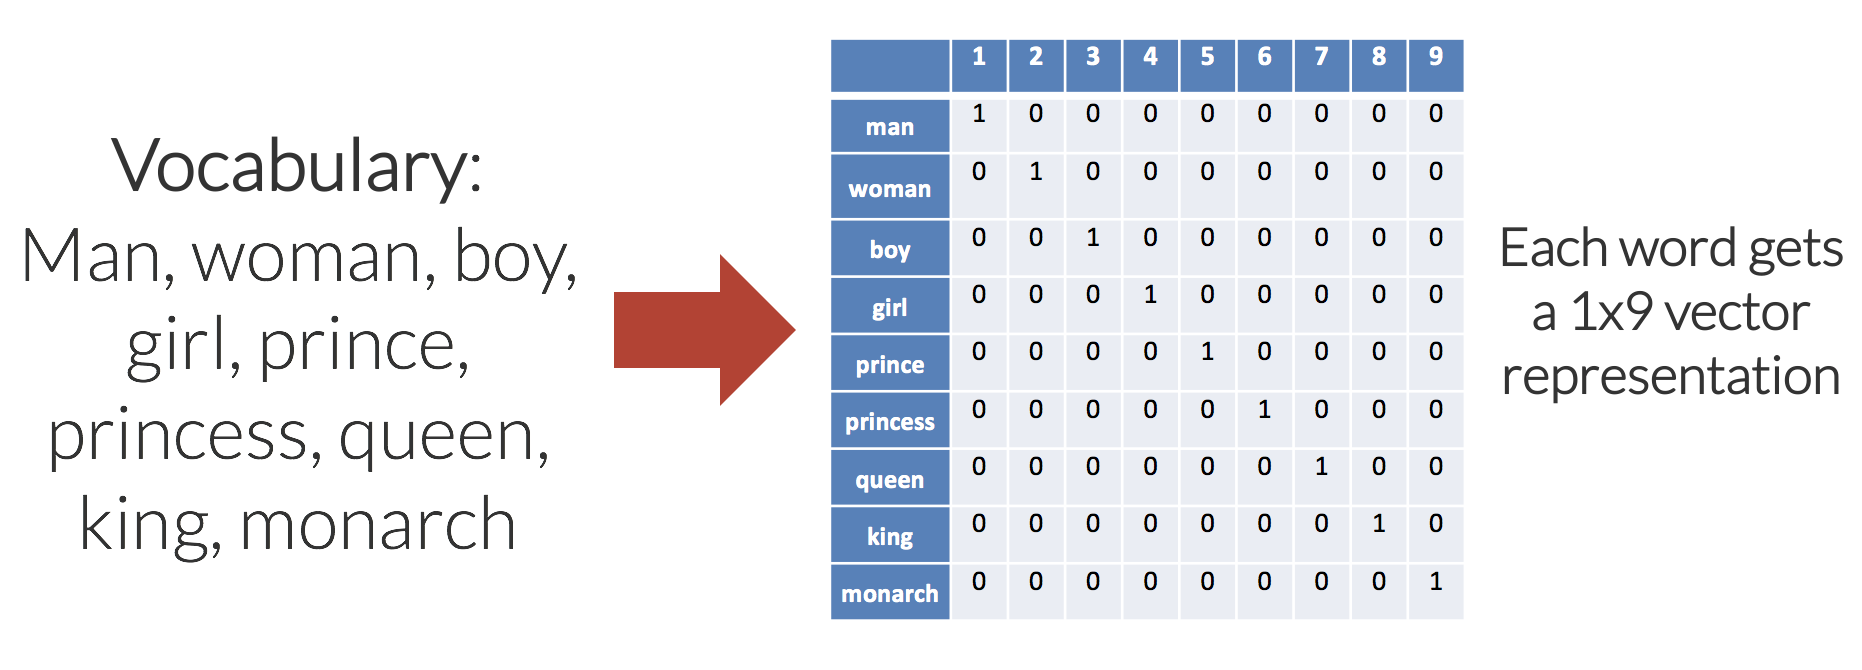

Una vez descargado y descomprimido este paquete, cargamos los ``KeyedVectors``, una manera de almacenar un embedding como un diccionario que permite ahorrar espacio de almacenamiento y memoria.

In [36]:
!wget https://zenodo.org/record/1410403/files/keyed_vectors.zip?download=1
!unzip /content/keyed_vectors.zip?download=1

--2023-02-21 20:58:38--  https://zenodo.org/record/1410403/files/keyed_vectors.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2933030481 (2.7G) [application/octet-stream]
Saving to: ‘keyed_vectors.zip?download=1.1’

keyed_vectors.zip?d 100%[===================>]   2.73G  26.1MB/s    in 1m 48s  

2023-02-21 21:00:28 (25.9 MB/s) - ‘keyed_vectors.zip?download=1.1’ saved [2933030481/2933030481]

Archive:  /content/keyed_vectors.zip?download=1
replace complete.kv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: complete.kv             
replace complete.kv.vectors.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace complete.kv.vectors.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: complete.kv.vectors.npy  


In [37]:
# Cargamos un modelo ya previamente entrenado ('complete.kv') y lo almacenamos en
# en el objeto word_vectors para utilizarlos en pasos posteriores
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load('complete.kv', mmap='r')

In [38]:
# Hacemos alguna comprobación previa para ver que funciona, en este caso por ejemplo
# buscamos las 5 palabras más parecidas a la palabra 'virus'
word_vectors.most_similar("virus", topn=5)

[('retrovirus', 0.759166955947876),
 ('bacilo', 0.6934126615524292),
 ('patógeno', 0.6908407211303711),
 ('Ébola', 0.6901521682739258),
 ('microorganismo', 0.6858637928962708)]

Generamos algunas pruebas comunes para poder visualizar de una manera rápida el diccionario que hemos obtenido con KeyedVectors

In [39]:
word_vectors.most_similar("crisis", topn=5)

[('recesión', 0.7563133239746094),
 ('depresión', 0.6926372051239014),
 ('crísis', 0.660133421421051),
 ('inestabilidad', 0.6597185730934143),
 ('catástrofe', 0.6559344530105591)]

In [ ]:
word_vectors.most_similar(positive=["país","españa"],negative=["francia"])

[('mundo', 0.7001003623008728),
 ('pueblo', 0.65839684009552),
 ('planeta', 0.6552746891975403),
 ('reino', 0.621232271194458),
 ('continente', 0.6127104759216309),
 ('país»', 0.5707250237464905),
 ('territorio', 0.5701130628585815),
 ('imperio', 0.5557019710540771),
 ('universo', 0.5479393005371094),
 ('ámbito', 0.5391291379928589)]

In [ ]:
word_vectors.doesnt_match(['virus', 'italia', 'españa'])

/usr/local/lib/python3.8/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'virus'

In [40]:
# También podremos sacar el vector de cada una de las palabras, en este caso con 400D
word_vectors.get_vector('virus')

memmap([ 1.2988902 , -1.6316934 ,  0.43645987,  1.0448985 , -0.41386238,
        -1.2694576 , -4.182667  ,  1.2103869 , -0.10899339,  1.3936069 ,
        -0.7022468 ,  0.33257946, -1.3396733 ,  1.4042599 ,  0.5464134 ,
         0.03323554, -0.52219707,  2.1274087 ,  0.9313742 ,  1.2654439 ,
        -1.615523  ,  1.0149124 ,  1.4229203 , -0.43049878, -1.0608798 ,
        -0.42400002, -1.5296111 , -0.05390504,  1.3632455 , -0.3738985 ,
         1.7665365 , -0.17367823,  0.1970949 ,  2.0665073 , -0.13440008,
         1.4209603 , -0.35774824, -2.7046351 , -2.5159853 ,  0.58939785,
        -0.26330772, -0.3056988 , -1.300254  , -0.8127447 ,  1.6072187 ,
         0.501126  , -0.6923823 , -0.05052102, -1.9589353 ,  1.7991768 ,
         0.22431369, -1.5840762 , -1.4285456 ,  1.6827251 , -0.8708958 ,
        -1.3287588 , -0.11224467,  1.0297577 , -1.6340499 ,  0.77646005,
         0.18055964, -0.77334607, -0.80816996, -1.6363105 ,  1.0468853 ,
        -1.6750333 ,  0.46902224,  1.0473593 , -2.1

In [41]:
# Generamos una función para volver a tokenizar el texto
def tokenize(texto):
  tweet_tokenizer = TweetTokenizer()
  tokens_list = tweet_tokenizer.tokenize(texto)
  return tokens_list

In [42]:
def get_average_vector(sentence):
  #retokenizamos con nuestra función
  tokens = tokenize(sentence)
  # Generamos lista de salida vacía
  lista = list()
  # Iteramos por cada token de la frase de entrada
  for i in tokens:
    # Si el token se encuentra en el embedding, añadir a la lista. 
    # Si no se encuentra (except), pasa al siguiente elemento.
    try:
      lista.append(word_vectors.get_vector(i))
    except:
      continue

  # Calculamos el valor medio de los vectores generados
  try:
    resultado = np.mean(lista, axis=0)  # 1vector - Dimension 400d
  except:
    # Si la lista está vacía, generar vector de ceros de tamaño el embedding
    resultado = np.zeros(400)
  return resultado

In [43]:
# Creamos una nueva columna llamada "embeddings" donde almacenaremos el resultado de aplicar
# la fórmula antes enunciada sobre la columna de nuestro texto normalizado
datos_ejercicio["embeddings"] = datos_ejercicio["Normalized"].progress_apply(lambda x: get_average_vector(x))

  5%|▌         | 435/8000 [00:01<00:16, 449.41it/s]/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
100%|██████████| 8000/8000 [00:10<00:00, 759.56it/s]


In [44]:
# Mostramos el resultado de esta columna
datos_ejercicio["embeddings"]

0       [-0.3440526, 0.3885615, -0.4880786, 0.72848535...
1       [-0.21048911, -0.16563156, -1.0118836, 0.38109...
2       [-0.3419272, -0.38419178, -0.15629451, -0.0264...
3       [-0.8773208, 0.08661149, -0.48118612, 0.604707...
4       [0.6834776, -0.8766524, 0.24572037, -0.4166016...
                              ...                        
7995    [-0.10194413, 0.003175831, -0.61062586, 0.5764...
7996    [-0.17391913, 0.06161058, -0.3360165, 0.906369...
7997    [0.075486906, 0.057859886, 0.3713758, 1.054717...
7998    [-0.20195687, -0.59115785, 0.20757098, 0.39299...
7999    [-0.68046206, -1.4056063, 0.9645605, -0.043149...
Name: embeddings, Length: 8000, dtype: object

Convertimos la columna de embeddings en un nuevo dataframe,  nos considerará cada una de las 400 dimensiones de los vectores como una característica y una columna.

In [45]:
datos_ejercicio["embeddings"].apply(pd.Series)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.344053,0.388561,-0.488079,0.728485,-0.202455,-0.975840,-0.999325,0.819222,-0.249189,-0.261109,...,-0.300383,0.274912,-0.932743,-0.779034,-0.474261,-0.363881,-0.348244,0.778833,1.018470,-0.633686
1,-0.210489,-0.165632,-1.011884,0.381096,-0.429285,-0.195044,-0.650738,0.096500,-0.126150,0.598259,...,0.313546,0.116102,-0.606455,0.681388,0.466758,-0.432539,0.105155,-0.587416,0.905941,0.227106
2,-0.341927,-0.384192,-0.156295,-0.026467,-0.603497,-0.331707,0.812296,0.653979,0.282087,0.048616,...,-0.020609,-0.555060,-0.226595,0.348110,0.486831,-0.285077,0.614681,0.101348,0.101356,-0.077470
3,-0.877321,0.086611,-0.481186,0.604707,-0.284199,0.741023,0.336880,0.806731,0.068803,0.441853,...,-0.107648,-0.376154,0.133010,-0.373858,0.103042,0.086692,0.320101,0.081227,0.008860,0.126178
4,0.683478,-0.876652,0.245720,-0.416602,-0.056643,0.469845,0.214081,0.303613,-0.092007,0.069941,...,0.113134,-0.531710,-0.385674,-0.137339,-0.547653,0.513489,0.183329,0.757763,-0.157975,-0.610897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-0.101944,0.003176,-0.610626,0.576461,-0.515194,0.231806,-0.359215,1.211609,-0.327455,1.122834,...,0.318346,-0.616938,-0.423998,0.112051,0.369631,-0.373558,0.364215,0.463121,0.566188,-0.375447
7996,-0.173919,0.061611,-0.336017,0.906370,0.202942,-0.072843,-0.646755,0.262809,0.292354,0.327105,...,0.155744,-0.725999,0.132722,0.872593,0.456284,-0.068919,0.345267,0.034712,-0.696139,-0.171968
7997,0.075487,0.057860,0.371376,1.054717,-0.160129,0.913301,-0.686235,0.428763,0.000453,1.052814,...,-0.497070,-0.607858,0.288460,-0.251896,-0.338852,-0.431614,0.975065,0.797935,-0.254132,-0.199083
7998,-0.201957,-0.591158,0.207571,0.392996,-0.396492,0.217385,-1.000477,0.579132,0.640300,0.128767,...,-0.004096,-0.377710,-0.144555,-0.310786,-0.118586,0.393761,-0.575535,0.177919,-0.483800,0.068514


Concatenamos embeddings y características extras conseguidas, como por ejemplo la presencia de URLs, hashtags o menciones

In [46]:
vector_data = pd.concat([datos_ejercicio.embeddings.apply(pd.Series),
                         datos_ejercicio[["MENTION_count", "URL_count", "hashtags_count"]]], axis=1)

In [48]:
#Comprobamos la dimensión del dataframe, que son las 400 dimensiones que teníamos
#más las 3 columnas nuevas que hemos generado
vector_data.shape

(8000, 403)

In [50]:
# Rellenamos los 0s
vector_data = vector_data.fillna(0)

Utilizamos la librería scipy (función sparse.hstack) para unir las características TFIDF (contenidas en "vector_data") con las que acabamos de seleccionar ("extra_features"). Esta unión nos generará una matriz X que utilizaremos para hacer el train-test split posteriormente:

In [51]:
import scipy as sp
# Extraemos las etiquetas y las asignamos a la variable y
y = datos_ejercicio["label"].values.astype(np.float32)
X = sp.sparse.csc_matrix(vector_data)

## 5. Entrenamiento y evaluación de modelos


Primero vamos a rebalancear nuestro dataset para poder trabajar correctamente sobre él. Dividiremos nuestro modelo en train y test y trabajaremos sobre el modelo de train, dejaremos el modelo de test exactamente igual que lo tenemos ahora mismo.

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)

(6000, 403)
(2000, 403)


Rebalanceo de clases: Tener un modelo desbalanceado nos pueude provocar problemas de rendimiento en el modelo.

Sólo se debe hacer rebalanceo en el conjunto de datos de entrenamiento. Si se hace en el de test estaremos evaluando el modelo resultante en un conjunto de datos con una distribución incorrecta.

In [53]:
# Cargamos
from imblearn.over_sampling import SMOTE 
# Creamos objetos
sm = SMOTE(random_state=42)
# Retransformamos
X_res, y_res = sm.fit_resample(X_train, y_train)

Observamos el resultado del rebalanceo:
Tantola clase 0 como la clase 1 observamos que tienen el mismo número de elementos

In [54]:
np.array(np.unique(y_res, return_counts=True)).T

array([[0.000e+00, 4.587e+03],
       [1.000e+00, 4.587e+03]])

**Decision de modelo de ML a utilizar**

En primer lugar se ha generado una función para medir la calidad de varios modelos estándar de forma fácil y ver sus resultados. 

La función hace un KFold y evalua diferentes modelos con una métrica de evaluación:

In [55]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings 
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #Para cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore') 
          # Generamos un Kfold
          KF = KFold(n_splits = 10, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)
          
          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)
          
          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

Una vez definida la función, podemos definir los modelos con los que hacer la evaluación. En este caso hemos incorporado la regresión logística, Random Forest, 
Árboles de Decisión y una Naive Bayes.

In [56]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB()),
         ("RandomForest",RandomForestClassifier(random_state=30)),
         ("DecisionTree",DecisionTreeClassifier(random_state=30))
]

# Mostraremos el accuracy de cada uno de los modelos para elegir el más adecuado
evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_res.toarray(), y_res)   

Metric: accuracy , KFold 
Logistic: 0.836385 (0.013332) 
Metric: accuracy , KFold 
GaussianNB: 0.733052 (0.014024) 
Metric: accuracy , KFold 
RandomForest: 0.904623 (0.009648) 
Metric: accuracy , KFold 
DecisionTree: 0.770987 (0.014718) 


([array([0.82135076, 0.8496732 , 0.83333333, 0.84313725, 0.86041439,
         0.82551799, 0.82769902, 0.81788441, 0.85059978, 0.83424209]),
  array([0.73093682, 0.74727669, 0.70697168, 0.73202614, 0.72955289,
         0.74045802, 0.71864776, 0.7568157 , 0.74482007, 0.72300981]),
  array([0.88453159, 0.90522876, 0.89324619, 0.92265795, 0.9040349 ,
         0.90621592, 0.90294438, 0.90948746, 0.91057797, 0.90730643]),
  array([0.77015251, 0.7788671 , 0.73965142, 0.75925926, 0.76772083,
         0.79389313, 0.77753544, 0.78844057, 0.76117775, 0.77317339])],
 ['Logistic', 'GaussianNB', 'RandomForest', 'DecisionTree'])

Una vez evaluados todos los modelos observamos que el que más nos conviene utilizar para nuestro modelo es el de Random Forest, que tiene una accuracy de 0.904 seguido de cerca por la Regresión Logística con un 0.836 y ya mucho menos acertados Naive Bayes y Árboles de decisión. Nos quedamos entonces con **Random Forest**

In [57]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# Definimos el modelo y sus parámetros
model = RandomForestClassifier(
            n_estimators = 100,   #Número de árboles en el bosque aleatorio
            oob_score    = True,  #Calculamos la puntuación out-of-bag (OOB) del modelo
            n_jobs       = -1,    #Número de trabajos paralelos que se deben ejecutar para el ajuste y la predicción. 
                                  #Establecemos -1, lo que significa que se utiliza el número de núcleos disponibles en el sistema.
            random_state = 123,   #Se utiliza para inicializar el generador de números aleatorios
            bootstrap = True,     #Utilizamos muestras de arranque (bootstrap samples) durante la construcción de los árboles
            max_features = 'auto' #Número máximo de características que se deben considerar al dividir un nodo. 
                                  #En este caso, se establece en 'auto', lo que significa que se selecciona el número de características automáticamente.
             )

In [ ]:
# En este caso había generado un grid que era demasiado complejo, entonces mi ordenador
# no era capaz de procesarlo

#grid = {'n_estimators': [100, 200, 500],
#        'max_depth': [3, 5, 7, None],
#        'min_samples_split': [2, 3, 4],
#        'min_samples_leaf': [1, 2, 3]}

#cv = KFold(n_splits=10)
#grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)


Definimos una cuadrícula de búsqueda (Grid Search) que utilizará para encontrar la mejor combinación de hiperparámetros para nuestro modelo de Random Forest

In [58]:
grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 3]
}

# Definimos objeto de validación cruzada KFold con 5 pliegues (n_splits=5), 
# que se utilizará para dividir los datos en conjuntos de entrenamiento y validación durante el ajuste de la cuadrícula de búsqueda.
cv = KFold(n_splits=5)

# Definimos un objeto de cuadrícula de búsqueda GridSearchCV, que utiliza el 
# modelo de Random Forest, la grid y algunos parámetros que se han elegido. 
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0) #Sacaremos el accuracy

Almacenamos en "grid_result" la búsqueda de todas las combinaciones posibles de hiperparámetros en la cuadrícula de búsqueda y ajusta un modelo de Random Forest para cada combinación

In [59]:
grid_result = grid_search.fit(X_train, y_train)

In [60]:
# Mostramos el resultado
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.793000 usando los parámetros {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}


Obtenemos una mejor accuracy de 0.793 usando los hiperparámetros escogidos.
Ahora tenemos que introducir los mejores resultados a un modelo específico para poder ser entrenado.

In [61]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model= RandomForestClassifier(
            n_estimators = 100,
            oob_score    = True,
            n_jobs       = -1,
            random_state = 123,
            bootstrap = True,
            max_features = 'auto'
             )
# Entrenamos el modelo
model.fit(X_res,y_res)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=123)

Predecimos con el set de test, y creamos una matriz de confusión y un "classification report".

In [62]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1423  120]
 [ 264  193]]
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88      1543
         1.0       0.62      0.42      0.50       457

    accuracy                           0.81      2000
   macro avg       0.73      0.67      0.69      2000
weighted avg       0.79      0.81      0.79      2000



Printeamos una matriz de confusión para ver los resultados de una manera más visual.
Observamos que tenemos una mayoría bastante importante de aciertos normales (1423) en nuestra predicción respecto a fallos 264), con lo cual creo que conseguimos finalmente un buen modelo de predicción.

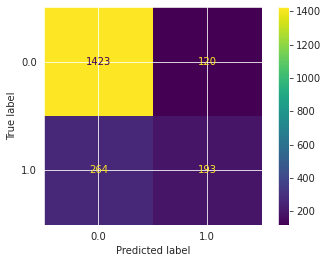

In [63]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, normalize = None)